In [2]:
import os
os.chdir('9444')
!pwd

/d/LSL/9444


# Load base model

## different size

size mismatch for text_decoder.bert.encoder.layer.9.crossattention.self.value.weight: copying a param with shape torch.Size([768, 1024]) from checkpoint, the shape in current model is torch.Size([768, 768]).
	size mismatch for text_decoder.bert.encoder.layer.10.crossattention.self.key.weight: copying a param with shape torch.Size([768, 1024]) from checkpoint, the shape in current model is torch.Size([768, 768]).
	size mismatch for text_decoder.bert.encoder.layer.10.crossattention.self.value.weight: copying a param with shape torch.Size([768, 1024]) from checkpoint, the shape in current model is torch.Size([768, 768]).
	size mismatch for text_decoder.bert.encoder.layer.11.crossattention.self.key.weight: copying a param with shape torch.Size([768, 1024]) from checkpoint, the shape in current model is torch.Size([768, 768]).
	size mismatch for text_decoder.bert.encoder.layer.11.crossattention.self.value.weight: copying a param with shape torch.Size([768, 1024]) from checkpoint, the shape in current model is torch.Size([768, 768]).


In [4]:
from transformers import BlipForConditionalGeneration, BlipForQuestionAnswering, BlipProcessor
from transformers import BertModel
from pprint import pprint
import torch

cache_dir = os.path.join('BLIP_checkpoints')
captioning_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large", cache_dir=cache_dir)
captioning_weights = captioning_model.state_dict()

vqa_model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base", cache_dir=cache_dir)
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base", cache_dir=cache_dir)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
vqa_model.to(device)

compatible_weights = {k: v for k, v in captioning_weights.items() if "vision_model" not in k and "crossattention" not in k}
# compatible_weights = {k: v for k, v in captioning_weights.items() if "crossattention" not in k}

missing_keys, unexpected_keys = vqa_model.load_state_dict(compatible_weights, strict=False)
print("Missing keys:")
pprint(missing_keys)
print("Unexpected keys:")
pprint(unexpected_keys)

bert_model = BertModel.from_pretrained("bert-base-uncased", cache_dir=cache_dir)
bert_model.resize_token_embeddings(30524)  # Resize BERT embeddings to match BLIP model vocabulary size
bert_weights = bert_model.state_dict()


# Lists for tracking successful, missing, and shape-mismatched layers
successful_layers = []
bert_missing_keys = []
bert_shape_mismatches = []

# Substitute relevant layers in the text encoder and text decoder only
for name, param in vqa_model.state_dict().items():
    # Ensure substitution only in text_encoder and text_decoder layers
    if "text_encoder" in name or "text_decoder" in name:
        # Match BERT layer name format by removing BLIP-specific prefixes
        bert_name = name.replace("text_encoder", "").replace("text_decoder.bert", "").strip(".")
        
        # Attempt to substitute weights if BERT layer exists and has matching shape
        if bert_name in bert_weights:
            if param.shape == bert_weights[bert_name].shape:
                try:
                    # Directly copy matching BERT layer weight
                    param.copy_(bert_weights[bert_name])
                    successful_layers.append(name)  # Track successfully loaded layers
                except Exception as e:
                    # Record failed layers due to errors
                    bert_shape_mismatches.append((name, str(e)))
            else:
                # Track layers with shape mismatch
                bert_shape_mismatches.append((name, bert_weights[bert_name].shape, param.shape))
        else:
            # Track missing BERT layer names
            bert_missing_keys.append(name)

# Display summary
print("Successfully loaded layers:")
pprint(successful_layers)
print("BERT missing keys:")
pprint(bert_missing_keys)
print("BERT shape mismatches:")
pprint(bert_shape_mismatches)


cuda
Missing keys:
['vision_model.embeddings.class_embedding',
 'vision_model.embeddings.position_embedding',
 'vision_model.embeddings.patch_embedding.weight',
 'vision_model.embeddings.patch_embedding.bias',
 'vision_model.encoder.layers.0.self_attn.qkv.weight',
 'vision_model.encoder.layers.0.self_attn.qkv.bias',
 'vision_model.encoder.layers.0.self_attn.projection.weight',
 'vision_model.encoder.layers.0.self_attn.projection.bias',
 'vision_model.encoder.layers.0.layer_norm1.weight',
 'vision_model.encoder.layers.0.layer_norm1.bias',
 'vision_model.encoder.layers.0.mlp.fc1.weight',
 'vision_model.encoder.layers.0.mlp.fc1.bias',
 'vision_model.encoder.layers.0.mlp.fc2.weight',
 'vision_model.encoder.layers.0.mlp.fc2.bias',
 'vision_model.encoder.layers.0.layer_norm2.weight',
 'vision_model.encoder.layers.0.layer_norm2.bias',
 'vision_model.encoder.layers.1.self_attn.qkv.weight',
 'vision_model.encoder.layers.1.self_attn.qkv.bias',
 'vision_model.encoder.layers.1.self_attn.projection

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Successfully loaded layers:
['text_encoder.embeddings.word_embeddings.weight',
 'text_encoder.embeddings.position_embeddings.weight',
 'text_encoder.embeddings.LayerNorm.weight',
 'text_encoder.embeddings.LayerNorm.bias',
 'text_encoder.encoder.layer.0.attention.self.query.weight',
 'text_encoder.encoder.layer.0.attention.self.query.bias',
 'text_encoder.encoder.layer.0.attention.self.key.weight',
 'text_encoder.encoder.layer.0.attention.self.key.bias',
 'text_encoder.encoder.layer.0.attention.self.value.weight',
 'text_encoder.encoder.layer.0.attention.self.value.bias',
 'text_encoder.encoder.layer.0.attention.output.dense.weight',
 'text_encoder.encoder.layer.0.attention.output.dense.bias',
 'text_encoder.encoder.layer.0.attention.output.LayerNorm.weight',
 'text_encoder.encoder.layer.0.attention.output.LayerNorm.bias',
 'text_encoder.encoder.layer.0.intermediate.dense.weight',
 'text_encoder.encoder.layer.0.intermediate.dense.bias',
 'text_encoder.encoder.layer.0.output.dense.weight

# Data Preprocessing

## Split

In [6]:
import os
from sklearn.model_selection import train_test_split
from datasets import load_dataset, Dataset

dataset_json_path = os.path.join('Dataset', 'merged_data_for_BLIP.json')

# training_data = load_dataset("json", data_files=dataset_json_path, split="train[:70%]")
# valid_data = load_dataset("json", data_files=dataset_json_path, split="train[70%:90%]")
# test_data = load_dataset("json", data_files=dataset_json_path, split="train[90%:100%]")

# 1 percent test
# full_dataset = load_dataset("json", data_files=dataset_json_path, split="train[:1%]")
# df = full_dataset.to_pandas()
# train_df, val_df = train_test_split(df, train_size=0.7, random_state=42)
# # Convert back to Hugging Face Datasets
# training_data = Dataset.from_pandas(train_df)
# valid_data = Dataset.from_pandas(val_df)

# 10 percent test
full_dataset = load_dataset("json", data_files=dataset_json_path, split="train[:1%]")
df = full_dataset.to_pandas()
train_df, val_df = train_test_split(df, train_size=0.7, random_state=42)
val_df, test_df = train_test_split(val_df, train_size=0.66, random_state=42)
# Convert back to Hugging Face Datasets
training_data = Dataset.from_pandas(train_df)
valid_data = Dataset.from_pandas(val_df)
test_data = Dataset.from_pandas(test_df)

##  Cache data locally

In [10]:
import torch
import os
from tqdm import tqdm
from PIL import Image

def cache_VQA(dataset, processor, cache_dir):
    os.makedirs(cache_dir, exist_ok=True)

    for idx in tqdm(range(len(dataset)), desc="Caching dataset"):
        # Define cache file path for each sample
        cache_path = os.path.join(cache_dir, f"sample_{idx}.pt")

        # Check if the file is already cached
        if os.path.exists(cache_path):
            continue  # Skip processing if the file already exists

        # Process each sample
        question = dataset[idx]['question']
        answer = dataset[idx]['answer']
        image_id = dataset[idx]['image_id']
        image_files_dir = os.path.join('Dataset', 'val2014')
        image_name = 'COCO_val2014_' + '0' * (12 - len(str(image_id))) + str(image_id) + '.jpg'
        image_path = os.path.join(image_files_dir, image_name)
        
        # Load and process image and text
        image = Image.open(image_path).convert("RGB")
        encoding = processor(image, question, padding="max_length", truncation=True, return_tensors="pt", return_attention_mask=True)
        labels = processor.tokenizer.encode(
            answer,
            max_length=8,
            truncation=True,
            padding="max_length",
            return_tensors='pt'
        )
        
        # Prepare tensors as in VQADataset
        encoding["labels"] = labels.squeeze()
        encoding["attention_mask"] = encoding["attention_mask"].squeeze()
        # Remove batch dimension for each tensor
        for k, v in encoding.items():
            encoding[k] = v.squeeze()

        # Save the preprocessed tensors
        torch.save(encoding, cache_path)  # Save to cache only if it wasn't already cached


In [ ]:
cache_dir = os.path.join('Dataset', 'cached_data', 'val2014')
os.makedirs(cache_dir, exist_ok=True)

cache_VQA(training_data, processor, os.path.join(cache_dir, "train"))
cache_VQA(valid_data, processor, os.path.join(cache_dir, "valid"))
cache_VQA(valid_data, processor, os.path.join(cache_dir, "test"))

Caching dataset: 100%|███████████████████████████████████████████████████████████████████████████████| 425/425 [00:20<00:00, 21.13it/s]


In [12]:
import torch

# Path to the .pt file
file_path = os.path.join(cache_dir, "train", 'sample_0.pt')

# Load the .pt file
data = torch.load(file_path)

# Print the contents
print("Data keys:", data.keys())  # Show the main keys in the dictionary

# Optionally, inspect individual elements
for key, value in data.items():
    print(f"{key}: Type = {type(value)}, Shape = {value.shape if hasattr(value, 'shape') else 'N/A'}")
    # If you want to see actual values, use print(value) or summarize as below
    print(f"Sample data from {key}: {value[:5] if value.numel() > 5 else value}")


Data keys: dict_keys(['pixel_values', 'input_ids', 'attention_mask', 'labels'])
pixel_values: Type = <class 'torch.Tensor'>, Shape = torch.Size([3, 384, 384])
Sample data from pixel_values: tensor([[[-0.6974, -0.7120, -0.7120,  ..., -1.1645, -0.4638, -0.6828],
         [-0.7120, -0.7120, -0.7120,  ..., -0.2594, -0.7120, -1.1499],
         [-0.7120, -0.7120, -0.7120,  ..., -0.8288, -0.8288, -1.5587],
         ...,
         [-1.1499, -1.1499, -0.7996,  ..., -1.4419, -1.6463, -1.3689],
         [-0.9748, -0.9456, -0.6244,  ..., -1.4127, -1.5879, -1.5587],
         [-0.7120, -0.9310, -0.8142,  ..., -1.4857, -1.5879, -1.6463]],

        [[ 0.0188,  0.0038,  0.0038,  ..., -0.9867,  0.2890,  0.0188],
         [ 0.0038,  0.0038,  0.0038,  ..., -0.0112, -0.2213, -0.9117],
         [ 0.0038,  0.0038,  0.0038,  ..., -0.7616, -0.4014, -1.1968],
         ...,
         [-1.0918, -1.1818, -0.8816,  ..., -1.3769, -1.5870, -1.3169],
         [-1.1368, -1.0467, -0.7166,  ..., -1.3469, -1.5270, -1.5120],

C:\Users\LIN\AppData\Local\Temp\ipykernel_37436\2393826167.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)


In [13]:
import torch
import os

class CachedVQADataset(torch.utils.data.Dataset):
    """Dataset for loading cached VQA data for training."""
    def __init__(self, cache_dir):
        self.cache_dir = cache_dir
        # List all cached files in the directory
        self.cache_files = sorted([f for f in os.listdir(cache_dir) if f.endswith('.pt')])

    def __len__(self):
        return len(self.cache_files)

    def __getitem__(self, idx):
        # Load preprocessed tensor data from the cache file
        cache_path = os.path.join(self.cache_dir, self.cache_files[idx])
        sample = torch.load(cache_path)  # This loads the dictionary of tensors

        # Each item is a tensor, no additional processing needed
        return sample


## Collate function

In [14]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

def custom_collate(batch):
    # Separate each element in the batch
    input_ids = [item["input_ids"] for item in batch]
    pixel_values = [item["pixel_values"] for item in batch]
    attention_mask = [item["attention_mask"] for item in batch]
    labels = [item["labels"] for item in batch]

    # Pad sequences to the maximum length in the batch
    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=0)  # Adjust padding_value as needed
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=-100)  # Use -100 for ignored labels in NLP

    # Stack other fixed-size tensors
    pixel_values_stacked = torch.stack(pixel_values)
    attention_mask_padded = pad_sequence(attention_mask, batch_first=True, padding_value=0)

    # Return the batch as a dictionary
    return {
        "input_ids": input_ids_padded,
        "pixel_values": pixel_values_stacked,
        "attention_mask": attention_mask_padded,
        "labels": labels_padded,
    }

## Prepare dataloader

In [27]:
train_cache_dir = os.path.join('Dataset', 'cached_data', 'val2014', 'train')
valid_cache_dir = os.path.join('Dataset', 'cached_data', 'val2014', 'valid')
test_cache_dir = os.path.join('Dataset', 'cached_data', 'val2014', 'test')

training_set = CachedVQADataset(train_cache_dir)
valid_set = CachedVQADataset(valid_cache_dir)
test_set = CachedVQADataset(test_cache_dir)

BATCH_SIZE = 16

train_dataloader = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate, num_workers=0, pin_memory=True)
valid_dataloader = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate, num_workers=0, pin_memory=True)
test_dataloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate, num_workers=0, pin_memory=True)


# LoRA config

In [17]:
for name, module in vqa_model.named_modules():
    pprint(name)

''
'vision_model'
'vision_model.embeddings'
'vision_model.embeddings.patch_embedding'
'vision_model.encoder'
'vision_model.encoder.layers'
'vision_model.encoder.layers.0'
'vision_model.encoder.layers.0.self_attn'
'vision_model.encoder.layers.0.self_attn.dropout'
'vision_model.encoder.layers.0.self_attn.qkv'
'vision_model.encoder.layers.0.self_attn.projection'
'vision_model.encoder.layers.0.layer_norm1'
'vision_model.encoder.layers.0.mlp'
'vision_model.encoder.layers.0.mlp.activation_fn'
'vision_model.encoder.layers.0.mlp.fc1'
'vision_model.encoder.layers.0.mlp.fc2'
'vision_model.encoder.layers.0.layer_norm2'
'vision_model.encoder.layers.1'
'vision_model.encoder.layers.1.self_attn'
'vision_model.encoder.layers.1.self_attn.dropout'
'vision_model.encoder.layers.1.self_attn.qkv'
'vision_model.encoder.layers.1.self_attn.projection'
'vision_model.encoder.layers.1.layer_norm1'
'vision_model.encoder.layers.1.mlp'
'vision_model.encoder.layers.1.mlp.activation_fn'
'vision_model.encoder.layers.1.

In [18]:
from pprint import pprint
from transformers import Conv1D
import torch

cleaned_bert_missing_keys = [name.rsplit(".", 1)[0] for name in bert_missing_keys]

# Define list of additional target layers (e.g., high-level layers and classification layers)
additional_layers = ["encoder.layer.10", "encoder.layer.11", "decoder.layer.10", "decoder.layer.11", "cls.predictions"]

# Create list of LoRA-compatible target modules that match either bert_missing_keys or additional_layers
target_modules = []

for name, module in vqa_model.named_modules():
    # Check if the module is in bert_missing_keys or additional_layers and is LoRA-compatible
    if any(missing_key in name for missing_key in cleaned_bert_missing_keys):
        if any(layer in name for layer in additional_layers):
            if isinstance(module, (torch.nn.Linear, torch.nn.Embedding, torch.nn.Conv2d, Conv1D)):
                target_modules.append(name)

# Display selected target modules
pprint(target_modules)


['text_encoder.encoder.layer.10.crossattention.self.query',
 'text_encoder.encoder.layer.10.crossattention.self.key',
 'text_encoder.encoder.layer.10.crossattention.self.value',
 'text_encoder.encoder.layer.10.crossattention.output.dense',
 'text_encoder.encoder.layer.11.crossattention.self.query',
 'text_encoder.encoder.layer.11.crossattention.self.key',
 'text_encoder.encoder.layer.11.crossattention.self.value',
 'text_encoder.encoder.layer.11.crossattention.output.dense',
 'text_decoder.bert.encoder.layer.10.crossattention.self.query',
 'text_decoder.bert.encoder.layer.10.crossattention.self.key',
 'text_decoder.bert.encoder.layer.10.crossattention.self.value',
 'text_decoder.bert.encoder.layer.10.crossattention.output.dense',
 'text_decoder.bert.encoder.layer.11.crossattention.self.query',
 'text_decoder.bert.encoder.layer.11.crossattention.self.key',
 'text_decoder.bert.encoder.layer.11.crossattention.self.value',
 'text_decoder.bert.encoder.layer.11.crossattention.output.dense',


In [19]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=8, # rank of the low-rank matrices that LoRA uses to modify certain parts of the model
    lora_alpha=16, # scale LoRA weights, effectively controlling how strongly the LoRA layers impact the model’s predictions
    lora_dropout=0.05, #
    bias="none", # whether or not to add biases to the LoRA-modified layers
    target_modules=target_modules       # specifies the exact layers in the model where LoRA should be applied, typically in attention mechanisms
                                        # ["q_proj", "k_proj"] are standard as they affect the query and key projections in attention layers
)

lora_model = get_peft_model(vqa_model, config)
lora_model.print_trainable_parameters()

trainable params: 459,232 || all params: 385,131,804 || trainable%: 0.1192


# Train (able to save checkpoint at each epoch and load from there)

In [24]:
def get_latest_session_and_checkpoint(root_folder):
    # Get list of all training sessions
    sessions = sorted([d for d in os.listdir(root_folder) if d.startswith('train')])
    if not sessions:
        return None, None

    # Latest session directory
    latest_session = sessions[-1]
    session_path = os.path.join(root_folder, latest_session)

    # Get the latest checkpoint in the latest session
    checkpoints = sorted([ckpt for ckpt in os.listdir(session_path) if ckpt.startswith('checkpoint')])
    if not checkpoints:
        return session_path, None

    latest_checkpoint = checkpoints[-1]
    return session_path, os.path.join(session_path, latest_checkpoint)

In [28]:
from tqdm import tqdm
import pickle

def train(model, processor, train_dataloader, valid_dataloader, num_epochs, root_folder='BLIP_checkpoints', resume_training=False, patience=3):
    # Locate the session path
    latest_session_num = max([int(d[5:]) for d in os.listdir(root_folder) if d.startswith('train')], default=0)
    session_num = latest_session_num + 1 if not resume_training else latest_session_num
    session_path = os.path.join(root_folder, f'train{session_num}')
    os.makedirs(session_path, exist_ok=True)

    # Path to save the best model
    best_model_path = os.path.join(session_path, 'best_model')
    os.makedirs(best_model_path, exist_ok=True)

    # Initialize training state
    start_epoch = 0
    min_eval_loss = float('inf')
    early_stopping_hook = 0

    # Load the latest checkpoint if resuming training
    if resume_training:
        latest_session_path, latest_checkpoint_path = get_latest_session_and_checkpoint(root_folder)
        if latest_checkpoint_path:
            print(f"Resuming from checkpoint at {latest_checkpoint_path}")
            base_model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base", cache_dir='BLIP_checkpoints\\')
            processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base", cache_dir='BLIP_checkpoints\\')
            model = PeftModel.from_pretrained(base_model, latest_checkpoint_path)
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            model.to(device)
            for param in model.parameters():
                param.requires_grad = False  # Set all params to non-trainable first
            for name, param in model.named_parameters():
                if "lora" in name:  # Customize based on LoRA layers naming convention
                    param.requires_grad = True
            model.print_trainable_parameters()
            start_epoch = int(latest_checkpoint_path.split('checkpoint')[-1])

    # Initialize the gradient scaler for mixed precision
    scaler = torch.amp.GradScaler("cuda")
    tracking_information = []
    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9, last_epoch=-1, verbose=False)

    for epoch in range(start_epoch, num_epochs):
        epoch_loss = 0
        model.train()

        for batch in tqdm(train_dataloader, desc=f'Training Epoch {epoch+1}/{num_epochs}'):
            input_ids = batch.pop('input_ids').to(model.device)
            pixel_values = batch.pop('pixel_values').to(model.device)
            attention_mask = batch.pop('attention_mask').to(model.device)
            labels = batch.pop('labels').to(model.device)

            with torch.amp.autocast("cuda"):
                outputs = model(input_ids=input_ids, pixel_values=pixel_values, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss

            epoch_loss += loss.item()
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        avg_epoch_loss = epoch_loss / len(train_dataloader)
        tracking_information.append({'epoch': epoch + 1, 'train_loss': avg_epoch_loss})

        # Validation step
        model.eval()
        eval_loss = 0

        with torch.no_grad():
            for batch in tqdm(valid_dataloader, desc=f'Validation Epoch {epoch+1}/{num_epochs}'):
                input_ids = batch.pop('input_ids').to(model.device)
                pixel_values = batch.pop('pixel_values').to(model.device)
                attention_mask = batch.pop('attention_mask').to(model.device)
                labels = batch.pop('labels').to(model.device)

                with torch.amp.autocast("cuda"):
                    outputs = model(input_ids=input_ids, pixel_values=pixel_values, attention_mask=attention_mask, labels=labels)
                    loss = outputs.loss
                    eval_loss += loss.item()

        avg_eval_loss = eval_loss / len(valid_dataloader)
        tracking_information[-1]['eval_loss'] = avg_eval_loss
        print(f"Epoch {epoch+1}: Training Loss = {avg_epoch_loss}, Validation Loss = {avg_eval_loss}")
        scheduler.step()

        # Save checkpoint at the end of each epoch
        checkpoint_path = os.path.join(session_path, f'checkpoint{epoch + 1}')
        model.save_pretrained(checkpoint_path)
        print(f"Checkpoint saved to {checkpoint_path}")

        # Save best model
        if avg_eval_loss < min_eval_loss:
            model.save_pretrained(best_model_path)
            min_eval_loss = avg_eval_loss
            early_stopping_hook = 0
            print(f"New best model saved at {best_model_path}")
        else:
            early_stopping_hook += 1
            if early_stopping_hook > patience:
                print("Early stopping triggered.")
                break

    # Save tracking information
    tracking_info_path = os.path.join(session_path, 'tracking_info.pkl')
    with open(tracking_info_path, "wb") as f:
        pickle.dump(tracking_information, f)
    print(f"Training complete. Tracking information saved to {tracking_info_path}")


In [29]:
from peft import PeftModel
NUM_EPOCHS = 30
PATIENCE = 10
ROOT_FOLDER = 'BLIP_checkpoints'

# Environment setup
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
torch.cuda.empty_cache()

# Start training
train(
    model=lora_model,
    processor=processor,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    num_epochs=NUM_EPOCHS,
    root_folder=ROOT_FOLDER,
    resume_training=False,  # Set to True to resume
    patience=PATIENCE
)


Training Epoch 1/30:   0%|                                                                                      | 0/94 [00:00<?, ?it/s]C:\Users\LIN\AppData\Local\Temp\ipykernel_37436\3663214271.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open 

Epoch 1: Training Loss = 8.003600868772953, Validation Loss = 3.8815091715918646
Checkpoint saved to BLIP_checkpoints\train12\checkpoint1
New best model saved at BLIP_checkpoints\train12\best_model


Validation Epoch 2/30: 100%|███████████████████████████████████████████████████████████████████████████| 27/27 [00:15<00:00,  1.75it/s]


Epoch 2: Training Loss = 1.6885812092334667, Validation Loss = 1.3850261502795749
Checkpoint saved to BLIP_checkpoints\train12\checkpoint2
New best model saved at BLIP_checkpoints\train12\best_model


Validation Epoch 3/30: 100%|███████████████████████████████████████████████████████████████████████████| 27/27 [00:15<00:00,  1.76it/s]


Epoch 3: Training Loss = 1.1639453958957753, Validation Loss = 1.2716081451486658
Checkpoint saved to BLIP_checkpoints\train12\checkpoint3
New best model saved at BLIP_checkpoints\train12\best_model


Training Epoch 4/30:  29%|██████████████████████                                                       | 27/94 [00:19<00:49,  1.36it/s]


KeyboardInterrupt: 

## Graph

In [ ]:
import os
os.chdir('9444')

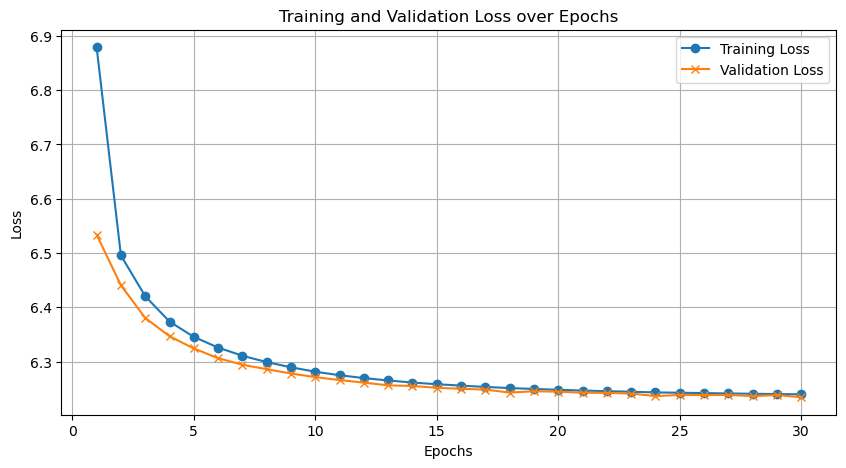

In [ ]:
import pickle
import matplotlib.pyplot as plt

tracking_info_path = 'BLIP_checkpoints/train6/tracking_info.pkl'
with open(tracking_info_path, "rb") as f:
    tracking_info = pickle.load(f)

epochs = [info['epoch'] for info in tracking_info]
train_losses = [info['train_loss'] for info in tracking_info]
val_losses = [info['eval_loss'] for info in tracking_info]

# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label="Training Loss", marker='o')
plt.plot(epochs, val_losses, label="Validation Loss", marker='x')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.grid()
plt.show()


# Test on an instance

In [ ]:
import os
os.chdir('9444')

Question: Where was this photo taken? Identify the state or region.
Answer: california


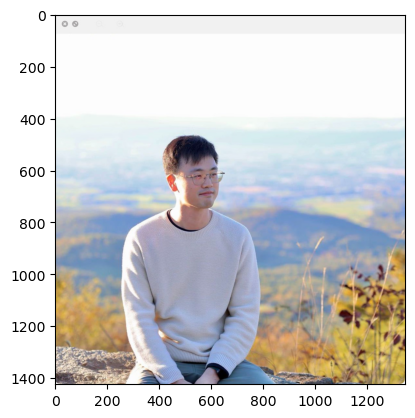

In [25]:
from transformers import BlipForQuestionAnswering, BlipProcessor
from peft import PeftModel
import torch
import matplotlib.pyplot as plt

# Load the base model
base_model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base", cache_dir='BLIP_checkpoints\\')
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base", cache_dir='BLIP_checkpoints\\')
# Load the LoRA adapters
adapter_model_path = "BLIP_checkpoints\\models--fine_tuned_2\\best_model"
lora_model = PeftModel.from_pretrained(base_model, adapter_model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lora_model.to(device)

# input
image_path = 'Dataset/1731044395244.jpg'
image = plt.imread(image_path)
plt.imshow(image)
plt.show;
question = "Where was this photo taken? Identify the state or region."
inputs = processor(images=image, text=question, return_tensors="pt").to(device)

# Generate an answer
with torch.no_grad():
    output = lora_model.generate(**inputs, max_new_tokens=20)
answer = processor.decode(output[0], skip_special_tokens=True)
print("Question:", question)
print("Answer:", answer)


Answer: tired


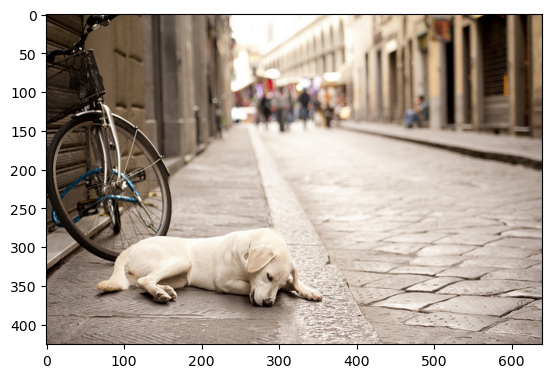

In [ ]:
# input
image_path = 'Dataset/val2014/COCO_val2014_000000000074.jpg'
image = plt.imread(image_path)
plt.imshow(image)
question = "how is the dog feeling?"
inputs = processor(images=image, text=question, return_tensors="pt").to(device)

# Generate an answer
with torch.no_grad():
    output = lora_model.generate(**inputs, max_new_tokens=20)
answer = processor.decode(output[0], skip_special_tokens=True)
print("Answer:", answer)


# Test on VQA benchmark

In [ ]:
import os
os.chdir('9444')

FileNotFoundError: [WinError 2] 系统找不到指定的文件。: '9444'

In [ ]:
from transformers import BlipForQuestionAnswering, BlipProcessor
from peft import PeftModel
import torch
import matplotlib.pyplot as plt

# Load the base model
base_model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base", cache_dir='BLIP_checkpoints\\')
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base", cache_dir='BLIP_checkpoints\\')
# Load the LoRA adapters
adapter_model_path = "BLIP_checkpoints\\models--fine_tuned_2\\best_model"
lora_model = PeftModel.from_pretrained(base_model, adapter_model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lora_model.to(device)

# input
image_path = 'Dataset/val2014/COCO_val2014_000000000164.jpg'
image = plt.imread(image_path)
# plt.imshow(image)
question = "how many aluminum cans in the image?"
inputs = processor(images=image, text=question, return_tensors="pt").to(device)

# Generate an answer
with torch.no_grad():
    output = lora_model.generate(**inputs, max_new_tokens=20)
answer = processor.decode(output[0], skip_special_tokens=True)
print("Answer:", answer)


Answer: 0


In [ ]:
# Predict answers
from pprint import pprint
import json
import os
import matplotlib.pyplot as plt

questions_path = os.path.join('Dataset', 'v2_OpenEnded_mscoco_val2014_questions.json')
with open(questions_path) as file:
    questions_file = json.load(file)
# pprint(questions_file['questions'])
questions = questions_file['questions']

answers_path = os.path.join('Dataset', 'BLIP_answers.json')
answers = []
count = 0
for question in questions:
    image_id = question['image_id']
    question_id = question['question_id']
    image_name = 'COCO_val2014_' + '0' * (12 - len(str(image_id))) + str(image_id) + '.jpg'
    image_path = os.path.join('Dataset', 'val2014', image_name)
    image = plt.imread(image_path)
    question_text = question['question']
    inputs = processor(images=image, text=question_text, return_tensors="pt").to(device)
    with torch.no_grad():
        output = lora_model.generate(**inputs, max_new_tokens=20)
    answer_text = processor.decode(output[0], skip_special_tokens=True)
    answers.append({
        "answer": answer_text,
        "question_id": question_id
    })
    print(count, ':', question_id, 'done')
    count += 1

with open(answers_path, 'w') as file:
    json.dump(answers, file, indent=4)

pprint(answers)


KeyboardInterrupt: 